**Step 1: Import Libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

**Step 2: Define dataset path**

In [3]:
DATA_DIR = r'C:\SCDMM'
IMAGE_DIR = os.path.join(DATA_DIR, 'images')
CSV_PATH = os.path.join(DATA_DIR, 'GroundTruth.csv')


**Step 3: Load Metadata**

In [4]:
df = pd.read_csv(CSV_PATH)

**Step 4: Map image to image path**

In [5]:
image_files = os.listdir(IMAGE_DIR)
image_dict = {f.split('.')[0]: os.path.join(IMAGE_DIR, f) for f in image_files}
df['image_path'] = df['image'].map(image_dict)

# Debugging: Check if 'image_path' exists
print("Columns in df:", df.columns)
print("Sample df:\n", df.head())

# Handle missing images
df = df.dropna(subset=['image_path'])
print("Missing image paths:", df['image_path'].isnull().sum())
print("Total images mapped:", len(df['image_path'].dropna()))


Columns in df: Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC',
       'image_path'],
      dtype='object')
Sample df:
           image  MEL   NV  BCC  AKIEC  BKL   DF  VASC  \
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0   
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0   
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0   
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0   
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0   

                         image_path  
0  C:\SCDMM\images\ISIC_0024306.jpg  
1  C:\SCDMM\images\ISIC_0024307.jpg  
2  C:\SCDMM\images\ISIC_0024308.jpg  
3  C:\SCDMM\images\ISIC_0024309.jpg  
4  C:\SCDMM\images\ISIC_0024310.jpg  
Missing image paths: 0
Total images mapped: 10015


**Step 5: Define class labels**

In [6]:
diagnosis_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
df['label'] = df[diagnosis_columns].idxmax(axis=1)
label_mapping = {cls: idx for idx, cls in enumerate(diagnosis_columns)}
df['label'] = df['label'].map(label_mapping)

**Step 6: Load and preprocess images**

In [7]:
def load_images(df, img_size=(128, 128)):
    images, labels = [], []
    for _, row in df.iterrows():
        img_path = row['image_path']
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize
        images.append(img)
        labels.append(row['label'])
    return np.array(images), to_categorical(labels, num_classes=len(diagnosis_columns))

**Step 7: Spliting Dataset**

In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
X_train, y_train = load_images(train_df)
X_test, y_test = load_images(test_df)

**Step 8: Building CNN model**

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(diagnosis_columns), activation='softmax')
])

c:\SCDMM\SCDenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Step 9: Compiling the model**

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Step 10: Training the model**

In [12]:
history=model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.8579 - loss: 0.3912 - val_accuracy: 0.7164 - val_loss: 0.8916
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.8702 - loss: 0.3605 - val_accuracy: 0.7204 - val_loss: 0.9049
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.8933 - loss: 0.2915 - val_accuracy: 0.7329 - val_loss: 0.9092
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - accuracy: 0.9283 - loss: 0.2183 - val_accuracy: 0.7059 - val_loss: 1.0818
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.9140 - loss: 0.2388 - val_accuracy: 0.7354 - val_loss: 1.0933
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - accuracy: 0.9451 - loss: 0.1646 - val_accuracy: 0.7119 - val_loss: 1.2529
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.9590 - loss: 0.1159 - val_accuracy: 0.7329 - val_loss: 1.4210
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.9606 - loss: 0.1249 

**Saving the model**

In [13]:
model.save('skincancer_model.keras')

**Plot training history**

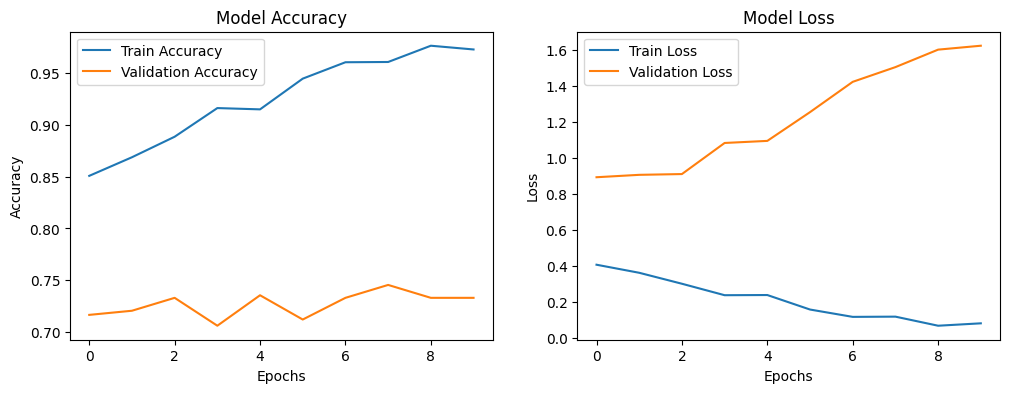

In [14]:
if 'accuracy' in history.history:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
else:
    print("Error: Training history is empty. Ensure model.fit() executes properly.")

In [15]:
print(f'Training samples: {X_train.shape}, Testing samples: {X_test.shape}')

Training samples: (8012, 128, 128, 3), Testing samples: (2003, 128, 128, 3)
